# IMDB sentiment analysis

**Problem Statement** : Automatically extract the feedback (positive or negative) on a movie from the IMDB reviews. The feedback can be used to help other customers to make decision to watch the movie or not and also can be used by the movie makers to know overall feedback of the movie.

- Steps
    - Dataset
    - Cleaning and pre-processing the data
    - Vectorize the data using TfIdf vectorization
    - Train the base model model
    - Experiment and Finetune with other classification ML models
    - Analyse the results
    - Improvement and Future work


## **Abstract**
Natural Language Processing (NLP) is a rapidly evolving field and the foundation for some of today's prominent Large Language Models. In this research, I analyzed approximately 50,000 IMDB movie reviews to train several foundational machine learning models, including Logistic Regression, Random Forest classifier, XGBoost classifier, and K-Nearest Neighbors (KNN) classifier, for movie sentiment classification as either Positive or Negative. The results indicate that the baseline Logistic Regression model with default parameters outperforms the other models, achieving an accuracy close to 90%. This study uses the benchmark set by Danyal et al. [1], who achieved around 90% accuracy with a Linear SVM model. In future work, I aim to experiment with deep learning models to determine if they offer any advantages over foundational models in terms of accuracy and training speed.

In [2]:
#import all required libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

In [3]:
# pip freeze
# Some of the important libaries with versions are mentioned here for reference
# This may not be the fulllist, please install the required libary as necessary

'''
matplotlib==3.7.1
matplotlib-inline==0.1.7
nltk==3.8.1
numpy==1.24.2
pandas==2.0.0
regex==2024.5.15
scikit-learn==1.3.2
tqdm==4.66.4
xgboost==2.0.3
'''


'\nmatplotlib==3.7.1\nmatplotlib-inline==0.1.7\nnltk==3.8.1\nnumpy==1.24.2\npandas==2.0.0\nregex==2024.5.15\nscikit-learn==1.3.2\ntqdm==4.66.4\nxgboost==2.0.3\n'

In [4]:
# Download all the stopwords (pre-trained on English) from the NLTK library
nltk.download('stopwords')

# Download the tokenizer (pre-trained on English) from the NLTK library
# This is used to tokenize the text into sentences and then extract abbrivatiions, collacations and words that starts the sentence
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prath\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dataset

In [5]:
# Read the data
data_frame = pd.read_csv('../Dataset/IMDB Dataset.csv')

In [6]:
data_frame.head(3) # Check the data on high level

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [7]:
print(f"Total number of reviews: {len(data_frame)}")

Total number of reviews: 50000


Text(0, 0.5, 'Count of reviews')

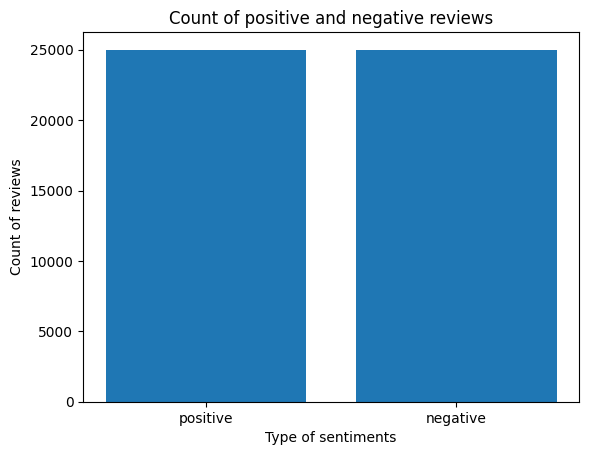

In [8]:
# Check if data is balanced, in our case we have a perfectly banalced data
data = data_frame['sentiment'].value_counts()
plt.bar(data.index, data.values)
plt.title('Count of positive and negative reviews')
plt.xlabel('Type of sentiments')
plt.ylabel('Count of reviews')


## **Data Cleaning, pre-processing and Vectorization**
##### Data cleaning and Pre-processing is the most important step for NLP tasks. 
##### _Data Cleaning_: The purpose of this step is to remove unnecessary data that are not contributing to the model training process. Here try to keep the characters that are alphanumeric mostly and also try to retain some emojii characters example :) and :(. 

In [9]:
wl = WordNetLemmatizer()
def clean_the_text(feature):
    '''
        input: column that needs cleaning - example reviews
        processing: Removes any special characters except for alphanumeric and :, ) and converts text to lowercase
        output: cleaned text
    '''
    cleaned_text = []
    for review in tqdm(feature):
        review = re.sub('[^A-Za-z0-9:)()]+', ' ', review) #Delete any character except alphanumeric - included :, (, ) to capture some more info
        review = review.lower() #Conver text to lower case
        cleaned_text.append(review)
    return(cleaned_text)

In [10]:
# Clean all the reviews and append the cleaned data to original data frame
cleaned_text_corpus = clean_the_text(data_frame['review'])
data_frame['cleaned_text'] = cleaned_text_corpus

100%|██████████| 50000/50000 [00:02<00:00, 24921.62it/s]


In [11]:
# Split the whole dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_frame['cleaned_text'], data_frame['sentiment'], test_size=0.2, random_state=42)

In [21]:
# Replace 'Positive' with 0 and 'Negative' with '1' for the labels
y_train = y_train.replace('negative', 1)
y_train = y_train.replace('positive', 0)
y_test = y_test.replace('negative', 1)
y_test = y_test.replace('positive', 0)

C:\Users\prath\AppData\Local\Temp\ipykernel_13604\3303015753.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace('positive', 0)
C:\Users\prath\AppData\Local\Temp\ipykernel_13604\3303015753.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = y_test.replace('positive', 0)


## **Vectorize the data**

#### ___Vectorization___ of the data is very important before feeding the data to the model. Since the algorithms understand the numbers and not the text, we vectorize the data.
#### There are many ways to vectorize the data, some of the traditional methods are to use ___One Hot Encoding___, __Bag of words___ and ___TFIDF Vectorization___.  On high level One Hot Encoding and Bag of words doesn't capture the semantics in the data and also results in sparse data leadning to expensive computation. For this particular implementation we use TFIDF vectorization
#### **TF-IDF Vectorization**: Helps representing the importance of a word in a document w.r.t collection of documents. 
$$ \text{Term Frequency (TF)} = \frac{\text{No. of times the term t appears in document d}}{\text{Total no. of terms in document d}} $$
$$ \text{Inverse Document Frequency (IDF)} = \frac{\text{Total documents}}{\text{No. of documents containing term t}} $$

#### The importance of the term is found by multiplying TF with IDF, higher the number more is the importance of the term

In [ ]:
# Instantiate the stemmer which is used for word lemmitization
stemmer  = SnowballStemmer(language='english')

def tokenizer(text):
    '''
    This function returns the word stem (root word) for any word by removing it's suffix and prefix 
    '''
    return [stemmer.stem(token) for token in word_tokenize(text.lower())]

In [23]:
# Print some of the stop words to get some idea
english_stopwords = stopwords.words('english')
' '.join(english_stopwords)

"a about above after again against ain all am an and any are aren aren't as at be because been before being below between both but by can couldn couldn't d did didn didn't do does doesn doesn't doing don don't down during each few for from further had hadn hadn't has hasn hasn't have haven haven't having he he'd he'll her here hers herself he's him himself his how i i'd if i'll i'm in into is isn isn't it it'd it'll it's its itself i've just ll m ma me mightn mightn't more most mustn mustn't my myself needn needn't no nor not now o of off on once only or other our ours ourselves out over own re s same shan shan't she she'd she'll she's should shouldn shouldn't should've so some such t than that that'll the their theirs them themselves then there these they they'd they'll they're they've this those through to too under until up ve very was wasn wasn't we we'd we'll we're were weren weren't we've what when where which while who whom why will with won won't wouldn wouldn't y you you'd you

In [24]:
# Initialize the TfIdf vectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer, #to tokenize the sentences and do stemming
                             stop_words=english_stopwords, #provide the stopwords to be removed
                             ngram_range=(1, 2), # here we conider both un-grams and bi-grams (for combination of words ex 'I love')
                             max_features=2500 # length of the vocabulary
                             )

In [25]:

# Fit the tfidf vectorizer for the training data
vectorizer.fit(data_frame['cleaned_text'])


e:\Tasks\Vijay\TaskB\VenvTaskB\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
e:\Tasks\Vijay\TaskB\VenvTaskB\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=2500, ngram_range=(1, 2),
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenizer at 0x0000010948D28040>)

In [26]:
# Apply the trained vectorizer to the train and test data
train_inputs = vectorizer.transform(X_train)
test_inputs = vectorizer.transform(X_test)

In [27]:
print(f"Total number of terms in the vocabulary: {len(vectorizer.vocabulary_)}")

Total number of terms in the vocabulary: 2500


In [28]:
vectorizer.get_feature_names_out()[:200] #no stop words or any other non required characters

array(['(', '( )', '( although', '( e', '( especi', '( even', '( like',
       '( one', '( play', '( though', ')', ') :', ') also', ') br',
       ') film', ') get', ') make', ') movi', ') one', '0', '000', '1',
       '1 10', '1 2', '10', '10 10', '10 br', '100', '11', '12', '13',
       '15', '2', '2 )', '2 10', '20', '20 minut', '3', '3 10', '30', '4',
       '4 10', '40', '5', '50', '6', '60', '7', '7 10', '70', '70s', '8',
       '8 10', '80', '80s', '9', '9 10', '90', '90 minut', ':', ': )',
       ': br', 'abandon', 'abil', 'abl', 'abov', 'absolut', 'absurd',
       'abus', 'academi', 'accent', 'accept', 'accid', 'accident',
       'accompani', 'accomplish', 'accord', 'account', 'accur', 'accus',
       'achiev', 'across', 'act', 'act bad', 'act like', 'action',
       'action movi', 'action scene', 'activ', 'actor', 'actor play',
       'actress', 'actual', 'ad', 'adam', 'adapt', 'add', 'addict',
       'addit', 'admir', 'admit', 'ador', 'adult', 'advanc', 'adventur',
       'a

In [29]:
# Note that each input is represented w.r.t the length of the vocabulary
train_inputs.shape

(40000, 2500)

In [30]:
train_inputs.toarray() # input is till sparse, the number represents the TFIDF for each term

array([[0.08656838, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0850251 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(40000, 2500))

## **Build a Baseline model** - Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression() #Initialize the model with default parameters
log_reg_model.fit(train_inputs, y_train) # Train the model

LogisticRegression()

In [32]:
y_preds = log_reg_model.predict(test_inputs) # predict the results

In [33]:
# Print the classification report

print(classification_report(y_preds, y_test))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5146
           1       0.88      0.90      0.89      4854

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



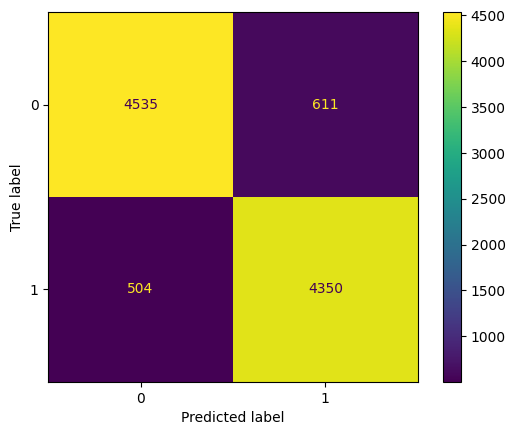

In [34]:
# Display the confusion matrix
cm = confusion_matrix(y_preds, y_test, labels=log_reg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_reg_model.classes_)
disp.plot()
plt.show()

## Now lets try some other models with hyperparameter tuning using GridSearchCV


#### Note: 
#### **Approach for hyperparameter tuning**: Since the data is large, performing hyper parameter tuning using GridSearch takes lots of time. Hence one approach here I considered is to perform the hyper parameter tuning on subset of the data and get the best parameters for the model before training the model on the whole dataset. I have also used Randomised Search CV wherever the parameter space is more.

#### **Approach on evaluating the results**: We calculate all the metrics such as Accuracy, Precision, recall and f1-score. The expectation is that these metrics will be almost same per model. This is because the dataset we have is perfectly balanced


#### Random Forest Classifier

In [35]:
# Train and predict RandomForest classifier
param_grid = {'n_estimators': [100, 200, 500], # Build the parameter grid
              'max_depth': [None, 5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}
rfc = RandomForestClassifier(random_state=0, verbose=True) # Initialize the model
rfc_grid_search = RandomizedSearchCV(rfc, param_distributions=param_grid, cv=5, n_iter=15) # Initialise the Randomised search CV
rfc_grid_search.fit(train_inputs[0:2000], y_train[:2000]) # Fit the Randomise search CV for sample data

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(random_state=0,
                                                    verbose=True),
                   n_iter=15,
                   param_distributions={'max_depth': [None, 5, 10, 15],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]})

In [36]:
rfc_best_model = rfc_grid_search.best_estimator_ # get the best model with best hyperparameter
rfc_best_model.fit(train_inputs, y_train) # train the model on train data
rfc_ypreds = rfc_best_model.predict(test_inputs) # predict the results
rfc_accuracy_score = accuracy_score(rfc_ypreds, y_test) # get the accuracy score
print(f"Accuracy of Randdom Forest Classifier is {rfc_accuracy_score}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy of Randdom Forest Classifier is 0.859


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


In [37]:
# print precision, accuracy, recall and f1-score for Randomforest classifer
print(classification_report(rfc_ypreds, y_test))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5077
           1       0.85      0.86      0.86      4923

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



#### XGB Classifier

In [38]:
param_grid = {'eta': [0.01, 1, 0.05]} # build the parameter grid
xgb_clf = XGBClassifier() #initialize the model
xgb_grid_search = GridSearchCV(xgb_clf, param_grid=param_grid, cv=5) # Initialize the GridSearchCV
xgb_grid_search.fit(train_inputs[0:2000], y_train[0:2000]) # Train the GridSearchCV on sample data

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'eta': [0.01, 1, 0.05]})

In [39]:
xgb_model = xgb_grid_search.best_estimator_ # get the model with best hyperparameters
xgb_model.fit(train_inputs, y_train) # train the model on train data
xgb_ypreds = xgb_model.predict(test_inputs) # predict the model on test data
xgb_accuracy_score = accuracy_score(xgb_ypreds, y_test) # get the accuracy score
print(f"Accuracy of XGB Classifier is {xgb_accuracy_score}")

Accuracy of XGB Classifier is 0.8193


In [40]:
# print precision, accuracy, recall and f1-score for XGB classifer
print(classification_report(xgb_ypreds, y_test))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      5480
           1       0.77      0.85      0.81      4520

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



#### KNN Classifier

In [41]:
k_range = list(range(1, 31)) # Ininitalise the k values
param_grid = dict(n_neighbors=k_range) # Initialise the parameter grid
knn_clf = KNeighborsClassifier() # Initialise the model
knn_grid_search = GridSearchCV(knn_clf, param_grid=param_grid, cv=5) # Ininitialise the GridSearchCV
knn_grid_search.fit(train_inputs[0:2000], y_train[0:2000]) # Train the GridSearchCV on sample data

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]})

In [42]:
knn_model = knn_grid_search.best_estimator_ # Get the KNN model with best hyper parameters
knn_model.fit(train_inputs, y_train) # fit the model on the test data
knn_ypreds = knn_model.predict(test_inputs) # predict the results
knn_accuracy_score = accuracy_score(knn_ypreds, y_test) # get the accuracy score
print(f"Accuracy of KNN Classifier is {knn_accuracy_score}")

Accuracy of KNN Classifier is 0.7676


In [43]:
# print precision, accuracy, recall and f1-score for KNN classifer
print(classification_report(knn_ypreds, y_test))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      5005
           1       0.77      0.76      0.77      4995

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



## Analysis on the performance of the models

| Algorithm | Train Time | Accuracy| Precision | Recall | f1-score |
|-----------|------------|---------|------------|-------|----------|
| Logistic Regression | ~ 1m 1s| 0.89 | 0.89 | 0.89 | 0.89 |
| Random Forest Classifier | ~ 20m 9s| 0.86 |0.86 |0.86 |0.86 |
| XGB Classifier | ~ 2m 54s| 0.82 |0.82 |0.82 |0.82 |
| KNN Classifier | ~ 20m 40s| 0.77 |0.77 |0.77 |0.77 |


Text(0, 0.5, 'Time taken in minutes')

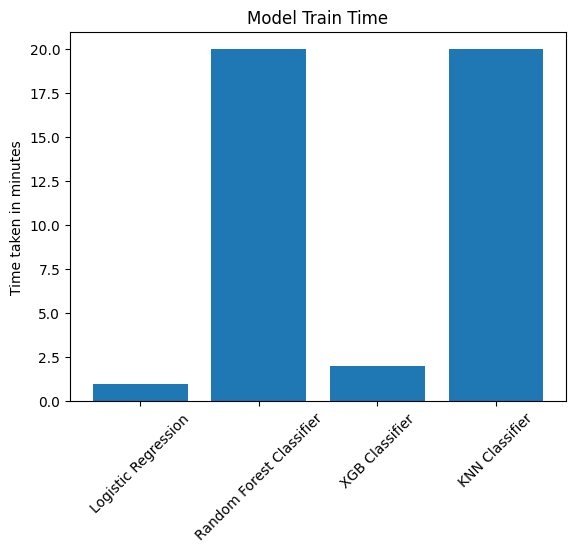

In [44]:
# plot the model's time taken time
train_time_taken = [1, 20, 2, 20]
models = ['Logistic Regression', 'Random Forest Classifier', 'XGB Classifier', 'KNN Classifier']
plt.bar(models, train_time_taken)
plt.xticks(rotation=45);
plt.title('Model Train Time')
plt.ylabel('Time taken in minutes')

#### Below we only plot the accuracy since all the metrics have same values (for each model)

Text(0, 0.5, 'Accuracy in %')

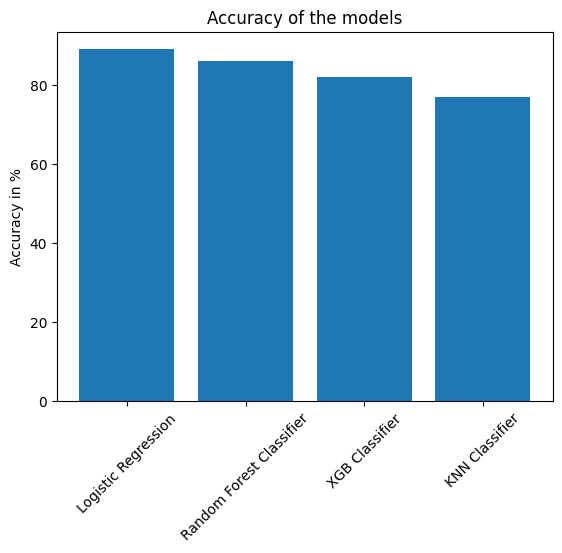

In [45]:

# Plot the accuracy of the models
models = ['Logistic Regression', 'Random Forest Classifier', 'XGB Classifier', 'KNN Classifier']
accuracy = [89, 86, 82, 77]
plt.bar(models, accuracy)
plt.xticks(rotation=45);
plt.title('Accuracy of the models')
plt.ylabel('Accuracy in %')

## **Conclusion** 
1. Out of all the models the baseline model of Logistic Regression (with default parameters) proves to be the best among all in terms of both accuracy and time taken to train the model.
2. The models Random forest classifer and XGB classifier came close to the baseline model in terms of accuracy but proved very costly in terms of computation
3. KNN classifier is the least performing among all the models

## **Comparision with other works** 
Work done by Danyal, et al [1] achieved around 90% accuracy. In this work, I have also achieved very close score with 89% accuracy for the baseline Logistic regression model.


[1]: Danyal, Mian Muhammad & Khan, Sarwar & Khan, Muzammil & Ghaffar, Muhammad & Khan, Bilal & Arshad, Muhammad. (2023). Sentiment Analysis Based on Performance of Linear Support Vector Machine and Multinomial Naïve Bayes Using Movie Reviews with Baseline Techniques. Journal on Big Data. 5. 1–18.. 10.32604/jbd.2023.041319. Read the post [here] (https://www.researchgate.net/publication/374193063_Sentiment_Analysis_Based_on_Performance_of_Linear_Support_Vector_Machine_and_Multinomial_Naive_Bayes_Using_Movie_Reviews_with_Baseline_Techniques)


## **Improvements and Future works**
1. Vecotrizing using Word2Vec captures more semantics than the TF-IDF vectorization. We can implement Word2Vec and see if it improves the performance
2. We can alter hyperparameters around TF-IDF vectorization, for example increasing the vocabulary size, using maximum n-grams to 3 4 and upto 5
3. We can analyse the stop words and see if they have any words that can help with our analysis for example, words like 'No' ,'Dont' etc appears in conjunction with negative reviews. So insetead of simply removing all the stop words, we can retain few that can help with model building.
4. The main drawback of the foundational machine learning models (Ex Random forest, KNN) is that it takes lots of time to train the model, alternatively we can employ deep learning approach and train the model on GPU 